In [1]:
from load_dataset import load_data
import utils
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
import pandas as pd

## Instancier le jeu de données

In [2]:
X, y, cat_features = load_data().get_data_X_y(data='simplify')

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Classification avec CatBoost

In [4]:
cat_clf = CatBoostClassifier(cat_features=cat_features, verbose=0, random_state=42)
cat_clf.fit(X_train, y_train)

print(f"Train Accuracy : {cat_clf.score(X_train, y_train) * 100:.3f} %")

Train Accuracy : 95.159 %


In [5]:
print(f"Test Accuracy : {cat_clf.score(X_test, y_test) * 100:.3f} %")

Test Accuracy : 91.552 %


In [6]:
preds = cat_clf.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.94      0.84      0.88       414
           1       0.91      0.96      0.93       675

    accuracy                           0.92      1089
   macro avg       0.92      0.90      0.91      1089
weighted avg       0.92      0.92      0.91      1089



In [7]:
from sklearn.metrics import f1_score

f1_score(y_test, cat_clf.predict(X_test), average='binary')

0.9340028694404592

In [8]:
# Validation croisée sur les données d'entraînement
cross_val = cross_val_score(cat_clf, X_train, y_train, cv=5)
cross_val

array([0.91748527, 0.90944882, 0.91338583, 0.91338583, 0.8976378 ])

In [9]:
print(f"Mean Cross-validation score sur le train dataset : {cross_val.mean() * 100:.3f}%")

Mean Cross-validation score sur le train dataset : 91.027%


## Feature Importance

In [10]:
utils.features_importance(cat_clf, X_train.columns, plot=False, log=False)

File features_importances.csv has been updated and saved.


,Importance
Unités curriculaires 2e semestre (approuvées),27.220402
Frais de scolarité à jour,8.417881
Cours,7.101919
Unités curriculaires 2e semestre (inscrits),5.634017
Unités curriculaires 1er semestre (approuvées),4.735262
Unités curriculaires 1er semestre (inscrits),4.535337
Unités curriculaires 2e semestre (note),4.060012
Bourse,3.155322
Unités curriculaires 1er semestre (note),3.131552
Occupation père,3.071165


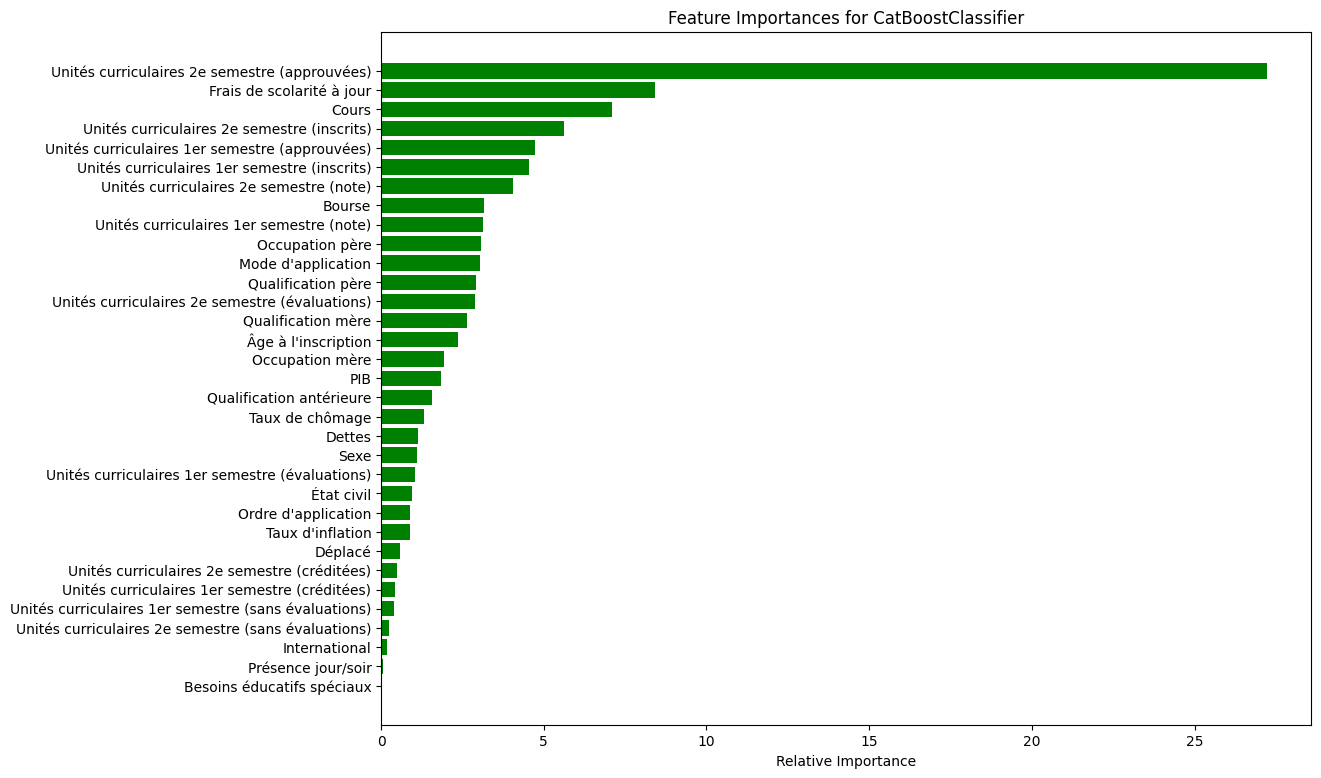

In [11]:
utils.features_importance(cat_clf, X_train.columns, plot=True)

### À voir si il y a de l'optimisation d'hyperparamètre à faire...

In [12]:
# Define the parameter grid to search
param_grid = {
    'iterations': [1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 9],
    'l2_leaf_reg': [1, 3, 5],
    'one_hot_max_size': [2, 150]
}

# Create a CatBoostClassifier
catboost_model = CatBoostClassifier(cat_features=cat_features, verbose=0, random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=catboost_model,
    param_grid=param_grid,
    scoring='f1',  # Use an appropriate scoring metric
    cv=3,  # Number of cross-validation folds
    n_jobs=-1,  # Use all available CPUs
    verbose=3,  # Set to 1 or higher for verbosity
)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding accuracy
print("Best Parameters: ", grid_search.best_params_)
print("Best F1: ", grid_search.best_score_)

model = grid_search.best_estimator_

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best Parameters:  {'depth': 6, 'iterations': 1000, 'l2_leaf_reg': 3, 'learning_rate': 0.01, 'one_hot_max_size': 150}
Best F1:  0.9276942732350474


In [13]:
model.fit(X_train, y_train)
print(f"Train Accuracy : {model.score(X_train, y_train) * 100:.3f} %")

Train Accuracy : 95.277 %


In [14]:
print(f"Test Accuracy : {model.score(X_test, y_test) * 100:.3f} %")

Test Accuracy : 91.368 %


In [15]:
preds = model.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.94      0.82      0.88       414
           1       0.90      0.97      0.93       675

    accuracy                           0.91      1089
   macro avg       0.92      0.90      0.91      1089
weighted avg       0.92      0.91      0.91      1089



In [16]:
from sklearn.metrics import f1_score

f1_score(y_test, model.predict(X_test), average='binary')

0.9329529243937233